 # XGBoost - Classification

**Using Optuna for hyper-parameter search  to predict TPSA from morphology profiles**

# Initialization

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [ ]:
# Models
import os, sys
import math
import pickle
import itertools
import copy 
import joblib
import logging 
# from multiprocessing import Pool, process
from datetime import datetime, time
from collections import defaultdict
from collections.abc import Iterator

for p in ['./src','../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
import pprint 
import warnings

import numpy as np
import pandas as pd
import scipy.stats as sps 
import sklearn.metrics as skm
import matplotlib.pyplot as plt



pp = pprint.PrettyPrinter(indent=4)
pd.options.display.width = 132
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')
warnings.filterwarnings('ignore')

# os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [37]:
del disp_study_history, disp_trial_info
from KevinsRoutines.utils.utils_gpu import display_gpu_info, display_gpu_device_info
from KevinsRoutines.utils.utils_optuna import disp_trial_info, disp_study_history
# from utils.utils_cellpainting import *
# from utils_ml import model_selection 


In [ ]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(name)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)

logger.info(f" Excution started : {timestamp} ")
# logger.info(f" Pytorch version  : {torch.__version__}")
# logger.info(f" Scipy version    : {scipy.__version__}") 
logger.info(f" Numpy version    : {np.__version__}")
logger.info(f" Pandas version   : {pd.__version__}  ")

insert ./src
insert ../..
['../..', './src', '/home/kevin/WSL-shared/cellpainting/cj-datasets', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']


2024-11-12 16:06:42,944 - __main__ - INFO: -  Excution started : 2024_11_12_16:06:42 
2024-11-12 16:06:42,945 - __main__ - INFO: -  Numpy version    : 1.26.2
2024-11-12 16:06:42,946 - __main__ - INFO: -  Pandas version   : 2.2.0  


In [4]:
import optuna
import dask
import sqlite3
import dask.array as da
import dask.dataframe as dd
from dask import delayed
from dask.distributed import Client
from dask.distributed import LocalCluster
from dask_cuda import LocalCUDACluster
import dask_ml.model_selection as dcv

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
import sklearn.metrics as skm

# from dask_ml.model_selection import train_test_split
# from dask_ml.model_selection import GridSearchCV, IncrementalSearchCV, HyperbandSearchCV
# from dask_ml.metrics import mean_squared_error, r2_score, mean_squared_log_error

## Datasets

In [7]:
from utils.jcp_datasets import project_datasets, display_project_datasets
ds = project_datasets(output_path = './output_11102023/')
# ds = project_datasets(output_path = './output_10162023/')
display_project_datasets(ds)

 Path and Prefixes : 
 ------------------- 
 prefix                                      : 
 prefix_lc                                   : 
 metadata path                               : ./metadata/
 input path                                  : ./input/
 output path                                 : ./output_11102023/

 Input & Metadata Datasets : 
 --------------------------- 
 Compound Metadata Input File                : ./metadata/compound.csv
 Plate Metadata Input File                   : ./metadata/plate_new.csv
 Well Metadata Input File                    : ./metadata/well.csv

 Profiles Metadata File                      : ./metadata/profile_metadata.pkl
 Parquet  Metadata File                      : ./metadata/parquet_columns.pkl

 Compound Metadata : 
 ------------------- 
 Metadata + Smiles                           : ./output_11102023/compound_metadata_smiles.csv
          + TPSA                             : ./output_11102023/compound_metadata_tpsa.csv
          + TPSA Cl

In [30]:
# prefix = '' ### Target-2' , 'MOA'
# input_path ="./metadata/"
# output_path ="./output_11102023"
# prefix_lc = prefix.lower().replace('-', '_')
# CSV = '.csv'
# x = 999

# CompoundExtendedMetadataSampleFile  = f"{output_path}{prefix_lc}/compound_extended_metadata_samples.csv"
# profileInputFiles                   = "./output_11102023/profiles/compound_profiles_2samples_{0:03d}.csv"
# binned_2SampleProfileFiles          = "./output_11102023/2_sample_profiles/binned_2sample_profiles_{0:03d}.csv"
# binned_3SampleProfileFiles          = "./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_{0:03d}.csv"

# CompoundExtendedMetadata2SampleFile = f"{output_path}{prefix_lc}/compound_extended_metadata_2samples.csv"
# print(f" Compound Extended Metadata 2 SampleFile  : {CompoundExtendedMetadata2SampleFile }")
# print()
# print(f" Compound Profiles 2 Samples File : {CompoundProfiles2SampleFile}")
# CompoundProfiles2SampleFile         = f"{output_path}{prefix_lc}/profiles/compound_profiles_2samples"
# profileMetadataFile                 = f"{input_path}profile_metadata.pkl"
# print(f" profiles Metadata File           : {profileMetadataFile}")
# print(f" profileInputFiles                : {profileInputFiles}")
# print(f" binned_2ProfileFiles             : {binned_2SampleProfileFiles}")
# print(f" binned_3ProfileFiles             : {binned_3SampleProfileFiles}")
# trainingMetrics                     = f"{output_path}{prefix_lc}/training_metrics.pkl"
# print(f" training metrics                 : {trainingMetrics}")


 # Compound Extended Metadata 2 SampleFile  : ./output_11102023/compound_extended_metadata_2samples.csv
 # Compound Profiles 2 Samples File CSV     : ./output_11102023/profiles/compound_profiles_2samples
 
 # profiles Metadata File                   : ./metadata/profile_metadata.pkl
 
 # profileInputFiles                        : ./output_11102023/profiles/compound_profiles_2samples_{0:03d}.csv
 # binned_2ProfileFiles                     : ./output_11102023/2_sample_profiles/binned_2sample_profiles_{0:03d}.csv
 # binned_3ProfileFiles                     : ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_{0:03d}.csv
 # training metrics                         : ./output_11102023/training_metrics.pkl

## Read Features metadata file

In [8]:
print(f" Features select file:  {ds.profileMetadataFile}")

 Features select file:  ./metadata/profile_metadata.pkl


In [9]:
with open(ds.profileMetadataFile, 'rb') as f: 
    pickle_data = pickle.load(f)

pickle_data.keys()

# COMPOUND_PROFILE_COLUMNS = pickle_data['all_profile_columns']  ## 3672 
COMPOUND_PROFILE_COLUMNS = pickle_data['metadata_columns']['MetadataNames'] + sorted(list(pickle_data['selected_columns']['selected']))  ## 1482

metadata_categorical_columns = set(pickle_data['metadata_columns']['MetadataCategoricalColumns'])
metadata_categorical_columns_dtype = pickle_data['metadata_columns']['MetadataCategoricalColumns']

metadata_float_columns =  set(pickle_data['metadata_columns']['MetadataFloatColumns'])
metadata_float_columns_dtype =  pickle_data['metadata_columns']['MetadataFloatColumns']

metadata_integer_columns =  set(pickle_data['metadata_columns']['MetadataIntegerColumns'])
metadata_integer_columns_dtype =  pickle_data['metadata_columns']['MetadataIntegerColumns']

metadata_numeric_columns =  set(pickle_data['metadata_columns']['MetadataNumericColumns'])
metadata_numeric_columns_dtype =  pickle_data['metadata_columns']['MetadataNumericColumns']


X_columns = pickle_data['selected_columns']['selected']
X_columns_dtype = {x: np.float32 for x in X_columns}

y_columns = set(["Metadata_Permiation"])
y_columns_dtype = {x: np.int64 for x in y_columns} ## "Metadata_log10TPSA":np.dtype('float64')}

Xy_columns = list(y_columns | X_columns)
Xy_columns_dtype = y_columns_dtype | X_columns_dtype
 

dict_keys(['all_profile_columns', 'metadata_columns', 'selected_columns', 'parquet_columns'])

## Display metadata info and constants used 

In [13]:
disp_metadata_file(pickle_data, COMPOUND_PROFILE_COLUMNS)

print(f" len(X_columms)                ({len(X_columns):4d})")
print(f" len(y_columms)                ({len(y_columns):4d}) {y_columns}")
print(f" len(Xy_columms)               ({len(Xy_columns)}) {list(Xy_columns)[:3]}")
print(f" len(Xy_columms_dtype)         ({len(Xy_columns)}) {list(Xy_columns_dtype)[:3]}")


--------------------------------------------------------------------------------
 all_profile_columns & COMPOUND_PROFILE_COLUMNS
--------------------------------------------------------------------------------
  Len all_profile_columns        : 3672
  Len COMPOUND_PROFILE_COLUMNS   : 1482

  all_profile_columns[:10]       : ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin', 'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA']
  COMPOUND_PROFILE_COLUMNS[:10]  : ['Metadata_Source', 'Metadata_Batch', 'Metadata_Plate', 'Metadata_Well', 'Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin', 'Metadata_TPSA', 'Metadata_lnTPSA', 'Metadata_log10TPSA']

  all_profile_columns[10:15]     : ['Metadata_Permiation', 'Cells_AreaShape_Area', 'Cells_AreaShape_BoundingBoxArea', 'Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_BoundingBoxMaximum_Y']
  COMPOUND_PROFILE_COLUMNS[10:15]: ['Metadata_Permiation', 'Cells_AreaSh

In [14]:
# profile_file= "./output_11102023/profiles/compound_profiles_2samples_002.csv"
# df_profiles = pd.read_csv(profile_file_001, header=0, names = all_columns, usecols=Xy_columns, dtype= Xy_columns_dtype, nrows =5)   
# df_profiles = pd.read_csv(profile_file, header=0, names = profileColumnNames, usecols=Xy_columns, dtype= Xy_columns_dtype, nrows =5)   

# Helper Functions

In [15]:
def train_model(iter_files, metric_keys = None, study_name = "", trial_num = 0, save = False, 
                **model_params):
    metrics_hist = defaultdict(list)
    my_model = None

    for i, ((X_train,y_train), (X_val, y_val)) in enumerate(iter_files):
        logging.info(f"CrossValidation split #{i}")
        logging.info(f"Building training & validation DMatrix...")

        d_train = xgb.dask.DaskDMatrix(client, X_train, y_train)
        d_val = xgb.dask.DaskDMatrix(client, X_val, y_val)

        logging.info(f"Training model...")
        # booster_model = my_model['booster'] if my_model is not None else None
        my_model = xgb.dask.train(
            None,
            model_params,
            d_train,
            # xgb_model = booster_model,
            num_boost_round=1000,
            evals=[(d_train, "train"), (d_val, "test")],
            verbose_eval=False,
            early_stopping_rounds = 50
        )
        # logging.info(f"Training model...Completed")

        logging.info(f"Running model on test data...")
        y_pred = xgb.dask.predict(client, my_model, d_val).compute()
        y_true = y_val.compute().to_numpy().squeeze()

        # Compute predictions and mean squared error for this iteration
        logging.info(f"Calculating metrics...")
        iter_metrics = compute_classification_metrics(my_model, y_true, y_pred)
        logging.info(f"Calculating metrics...Completed")

        print("-" * 80)
        for key in metric_keys:
            metrics_hist[key].append(iter_metrics[key])
            print(f" {key:20s}: {iter_metrics[key]:9.5f}")
        print("-" * 80)

        del d_train, d_val, X_train, y_train, X_val, y_val, y_true, y_pred

    ## End of loop
    return my_model, metrics_hist


def objective(trial, disp_params = True, save = True):
    metric_keys = ["train_auc","train_logloss", "val_auc", "val_logloss", "roc_auc", "logloss",
                   "accuracy","bal_acc","top_k_acc","F1_score","map","pearson_corr"]
    CV_FOLDS = 5
    obj = "binary:logistic"
    eval_metric =["auc","logloss"]

    study_params = propose_parameters(trial, obj, eval_metric)
    study_params = {"booster"      : "gbtree",
                    "device"       : "gpu",
                    # "objective"    :  "binary:logistic",
                    # "eval_metric"  :  ["auc", "logloss"],
                    "verbosity"    : 0,
                    "disable_default_eval_metric" : False,
                    ** study_params}
    print('-'*80)
    print(f" Training model (trial #{trial.number}) ")
    print('-'*80)

    if disp_params:
        print(f" Parameters:")
        for k, v in study_params.items():
            print(f"  {k:30s} {v}")

    iter_files = make_cv_splits_2(input_file_list, n_folds=CV_FOLDS, y_columns=y_columns)
    model, metrics = train_model(iter_files, metric_keys = metric_keys,
                                 study_name = study.study_name,
                                 trial_num = trial.number,
                                 save = True,
                                 ** study_params)

    print_metric_hist(metrics)
    print(f" model best score    :  {model['booster'].best_score}")
    print(f" model best iteration:  {model['booster'].best_iteration}")

    if save:
        save_as_filename = "./saved_models/{0}_trial_{1:03d}.json".format(study.study_name,trial.number)
        print(f" Save model to : {save_as_filename}")
        model['booster'].save_model(save_as_filename)

    r1 = np.array(metrics['val_auc']).mean()
    r2 = np.array(metrics['val_logloss']).mean()
    del model, metrics
    return r1,r2

# Dask - create cluster and client 

In [47]:
# !nvidia-smi

In [16]:
try:
    cluster.close()
    del cluster
except Exception as e:
    print("Cluster doesn't exist")
else:
    print("Cluster close succeeded")

Cluster doesn't exist


In [17]:
n_workers = 3
n_threads = 2
cuda_visible_devices = [0,1,2]
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES=[0,1,2],
                           n_workers=n_workers, 
                           threads_per_worker= n_threads,
                           memory_limit='6GB',
                           silence_logs = logging.WARNING)
# cluster = LocalCluster("Kevins_Cluster", n_workers=n_workers, threads_per_worker= n_threads, silence_logs = logging.WARNING)
print(f" Cluster dashboard link : {cluster.dashboard_link}")

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(
/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


 Cluster dashboard link : http://127.0.0.1:8787/status


In [18]:
# print(cluster)
# print(f" Cluster dashboard link : {cluster.dashboard_link}")
# cluster.workers[2].restart
# cluster.start_worker
# cluster.worker_spec
# cluster.scale(3)

In [19]:
try:
    client.close()
    del client
except Exception as e:
    print(" *** Client close failed *** ")
else:
    print(" *** Client close succeeded *** ")
finally:
    client = Client(cluster)    
    print(f"\n *** Client created - {client.status} ")
    client

 *** Client close failed *** 

 *** Client created - running 


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 3
Total threads: 6,Total memory: 16.76 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42237,Workers: 3
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 16.76 GiB
Comm: tcp://127.0.0.1:46847,Total threads: 2
Dashboard: http://127.0.0.1:34109/status,Memory: 5.59 GiB
Nanny: tcp://127.0.0.1:33313,


# Load Training and Test datasets

  ### Load header information for compound_profile datasets

In [21]:
# df_header = pd.read_csv("./output_11102023/2_sample_profiles/binned_2sample_profiles_3681_header_info.csv")
# df_header
# COMPOUND_PROFILE_COLUMNS_3681 = df_header.columns.to_list()
# len(COMPOUND_PROFILE_COLUMNS_3681)

In [22]:
# df_profiles = read_cell_profiles(input_files[i], names = COMPOUND_PROFILE_COLUMNS, usecols = Xy_columns, dtype = Xy_columns_dtype)
# df_profiles = read_cell_profiles(training_files, names = COMPOUND_PROFILE_COLUMNS, usecols = Xy_columns, dtype = Xy_columns_dtype)
# file_idxs = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

# TRAINING_FILES = {0, 1, 2, 4, 5, 6, 7, 8, 9, 11}
# TEST_FILES = {3, 10}
TRAINING_FILES = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
TEST_FILES = {15}
binnedProfileFiles = binned_3SampleProfileFiles
print(binnedProfileFiles)

./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_{0:03d}.csv


In [23]:
## retutn a list of dask dataframes

input_file_list = read_binned_profile_files(filename = binnedProfileFiles,
                                            file_idxs = TRAINING_FILES,
                                            names = COMPOUND_PROFILE_COLUMNS,
                                            # names = COMPOUND_PROFILE_COLUMNS_3681,
                                            usecols = Xy_columns,
                                            dtype = Xy_columns_dtype,
                                            index_cols = False,)

2024-08-12 16:46:43,682 - root - INFO: -  Read profiles file ...


 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_000.csv    {'index_cols': False}
 Reading ALL  rows - Number of partitions:  9   

 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_001.csv    {'index_cols': False}
 Reading ALL  rows - Number of partitions:  9   

 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_002.csv    {'index_cols': False}
 Reading ALL  rows - Number of partitions:  9   

 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_003.csv    {'index_cols': False}
 Reading ALL  rows - Number of partitions:  9   

 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_004.csv    {'index_cols': False}
 Reading ALL  rows - Number of partitions:  9   

 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_005.csv    {'index_cols': F

2024-08-12 16:46:46,587 - root - INFO: -  Read profiles file ... complete


 Reading ALL  rows - Number of partitions:  9   



In [37]:
ttl = 0 
for p in range(len(input_file_list)):
    ss = input_file_list[p].map_partitions(len).compute()
    ttl += ss.sum()
    print(f" partition {p}   rows {ss.sum()}    ttl rows: {ttl}")

 partition 0   rows 21779    ttl rows: 21779
 partition 1   rows 21434    ttl rows: 43213
 partition 2   rows 21803    ttl rows: 65016
 partition 3   rows 21713    ttl rows: 86729
 partition 4   rows 21755    ttl rows: 108484
 partition 5   rows 21314    ttl rows: 129798
 partition 6   rows 21350    ttl rows: 151148
 partition 7   rows 21833    ttl rows: 172981
 partition 8   rows 21290    ttl rows: 194271
 partition 9   rows 21605    ttl rows: 215876
 partition 10   rows 21782    ttl rows: 237658
 partition 11   rows 21644    ttl rows: 259302
 partition 12   rows 22013    ttl rows: 281315
 partition 13   rows 21653    ttl rows: 302968
 partition 14   rows 21632    ttl rows: 324600


In [24]:
iter_files = make_cv_splits_2(input_file_list, n_folds=5, y_columns=y_columns)

In [25]:
for i in iter_files:
    type(i)

 # bin files: 15   # of folds 5 -  (groups of 3 file tuples)
CV Split 0 -  Training files: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]   Validation files: [0, 1, 2]  


tuple

CV Split 1 -  Training files: [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]   Validation files: [3, 4, 5]  


tuple

CV Split 2 -  Training files: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]   Validation files: [6, 7, 8]  


tuple

CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14]   Validation files: [9, 10, 11]  


tuple

CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   Validation files: [12, 13, 14]  


tuple

# Setup XGBoost ML environment

In [20]:
xgb.__version__
xgb.config_context(device = "gpu", booster = "gbtree", verbosity = 0, validate_parameters = True ) 

'2.0.3'

# Load Optuna Database for hyper-parameter search

## Load study

  #### Address for optuna dashboard repository:  `sqlite:////home/kevin/WSL-shared/Cellpainting/cj-datasets/optuna_database.db`

In [16]:
db_path = "../cj-datasets/optuna_database.db"
storage_url = "sqlite:///../cj-datasets/optuna_database.db"

In [17]:
# storage = "sqlite:///example.db"
# storage_copy = "sqlite:///example_copy.db"
# study_name ="classification-2SampleStudy-Apr24"
# study_name ="cls-3_SampleStudy-Aug09"
# study_name="classification-study-1"
## https://optuna.readthedocs.io/en/stable/reference/generated/optuna.storages.RetryFailedTrialCallback.html
#
from optuna.storages import RetryFailedTrialCallback
#
storage_instance = optuna.storages.RDBStorage(
    url=storage_url,
    heartbeat_interval=60,
    grace_period=120,
    failed_trial_callback=RetryFailedTrialCallback(max_retry=3),
)
# storage_instance

In [27]:
with sqlite3.connect(db_path) as conn:
    conn.row_factory = sqlite3.Row
    results = conn.execute("SELECT * FROM studies ;").fetchall()
    db_studies = [dict(r) for r in results]
for i,ent in enumerate(db_studies):
    print(f" {i} - {ent}")

 0 - {'study_id': 6, 'study_name': 'classification-study-Apr24'}
 1 - {'study_id': 7, 'study_name': 'classification-3SampleStudy-Apr24'}
 2 - {'study_id': 10, 'study_name': 'cls-3_SampleStudy-Aug09'}
 3 - {'study_id': 12, 'study_name': 'test_study_01'}
 4 - {'study_id': 13, 'study_name': 'embd_cls_XGB_base_unbal'}
 5 - {'study_id': 14, 'study_name': 'embd_cls_XGB_snnl_unbal'}
 6 - {'study_id': 15, 'study_name': 'classification-study-Feb24'}
 7 - {'study_id': 16, 'study_name': 'embd_cls_XGB_base_bal_1:1'}
 8 - {'study_id': 17, 'study_name': 'embd_cls_XGB_snnl_bal_1:1'}
 9 - {'study_id': 18, 'study_name': 'embd_cls_XGB_snnl_unbal_Aug13'}


In [45]:
# study_name ='classification-3SampleStudy-Apr24'
# study_name ='classification-study-Apr24'
# study_name ='classification-study-1'
# study_name ='cls-3_SampleStudy-Aug09'
for i in [4,5,9]:
    study_name = db_studies[i]['study_name']
    study  = optuna.load_study(study_name= study_name, storage=storage_instance)
    disp_study_history(study, best_only = True)

 embd_cls_XGB_base_unbal  study history

 Total trials in study: 90
 Best trials: [21, 41, 44, 63, 71]
                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 21   2024-08-09   18:01:05 - 18:02:10    1      0.60700        0.35187    
Trial #: 41   2024-08-09   19:46:13 - 19:47:43    1      0.60590        0.35024    
Trial #: 44   2024-08-09   19:50:16 - 19:51:08    1      0.58397        0.34572    
Trial #: 63   2024-08-09   20:59:32 - 21:00:24    1      0.59100        0.34950    
Trial #: 71   2024-08-09   21:08:42 - 21:09:34    1      0.56287        0.33219    
 *** end of trials *** 
 embd_cls_XGB_snnl_unbal  study history

 Total trials in study: 98
 Best trials: [42, 66, 71, 73, 82, 85]
                start     -   completion      status        validation metrics
 trial#         time      -

In [47]:
# for i in [7,8]:
#     study_name = db_studies[i]['study_name']
#     study  = optuna.load_study(study_name= study_name, storage=storage_instance)
#     disp_study_history(study, best_only = True)

In [44]:
for i in [5,9]:
    study_name = db_studies[i]['study_name']
    study  = optuna.load_study(study_name= study_name, storage=storage_instance)
    disp_study_history(study, best_only = True)

 embd_cls_XGB_snnl_unbal  study history

 Total trials in study: 98
 Best trials: [42, 66, 71, 73, 82, 85]
                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 42   2024-08-09   22:40:01 - 22:40:56    1      0.59293        0.34882    
Trial #: 66   2024-08-09   23:05:08 - 23:06:17    1      0.60470        0.35399    
Trial #: 71   2024-08-09   23:11:28 - 23:12:59    1      0.60693        0.35503    
Trial #: 73   2024-08-09   23:14:26 - 23:15:51    1      0.60576        0.35457    
Trial #: 82   2024-08-09   23:24:35 - 23:25:46    1      0.60157        0.35384    
Trial #: 85   2024-08-09   23:27:56 - 23:28:54    1      0.58032        0.30545    
 *** end of trials *** 
 embd_cls_XGB_snnl_unbal_Aug13  study history

 Total trials in study: 65
 Best trials: [47, 49]
                start     - 

In [40]:
# resp = input(f" Delete study {study_name} ?")
# if resp.lower() in ['yes' ,'y']:
#     print(' You responsed yes')
#     try:
#         optuna.delete_study(storage=storage_instance, study_name=study_name)
#         print("delete successful")
#     except Exception as e:
#         print("delete failed")
# else:
#     print(f" {study_name} will be kept")

# study = optuna.create_study(storage=storage_instance,
#                             study_name=study_name,
#                             directions=["maximize","minimize"], 
#                             load_if_exists=True)
# study.set_metric_names(["roc_auc", "logloss"])

In [ ]:
study_name ="cls-3_SampleStudy-Aug09"
study  = optuna.load_study(study_name= study_name, storage=storage_instance)
disp_study_history(study)

# Run studies

In [43]:
start = datetime.now()

study.optimize(objective, n_trials=4, timeout=3600*7, gc_after_trial=True, show_progress_bar=False)

print(f"Total time:  {datetime.now() - start}")

--------------------------------------------------------------------------------
 Training model (trial #14) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.02324537679664609
  gamma                          7.255739028373606
  max_depth                      15
  min_child_weight               9.936303907650505
  max_delta_step                 9.46443705238088
  subsample                      0.9822678581831684
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.6751740319507228
  colsample_bynode               0.999022634834442
  lambda                        

2024-08-12 16:54:10,472 - root - INFO: - CrossValidation split #0
2024-08-12 16:54:10,473 - root - INFO: - Building training & validation DMatrix...
2024-08-12 16:54:53,245 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2024-08-12 16:54:53,927 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-08-12 16:54:54,389 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-08-12 16:54:54,706 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-08-12 16:54:55,003 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-08-12 16:54:55,275 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-08-12 16:54:56,050 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.99433
 train_logloss       :   0.22372
 val_auc             :   0.62408
 val_logloss         :   0.34980
 roc_auc             :   0.62508
 logloss             :   0.34980
 accuracy            :   0.88260
 bal_acc             :   0.00454
 top_k_acc           :   1.00000
 F1_score            :   0.00960
 map                 :   0.20367
 pearson_corr        :   0.17653
--------------------------------------------------------------------------------
CV Split 1 -  Training files: [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]   Validation files: [3, 4, 5]  


2024-08-12 16:59:42,968 - root - INFO: - CrossValidation split #1
2024-08-12 16:59:42,969 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:00:48,077 - root - INFO: - Training model...
2024-08-12 17:00:48,086 - root - INFO: - start listen on 10.91.28.16:50549
[17:00:48] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:00:48] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:00:48] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:00:48,123 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:04:45,806 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:04:46,140 - root - INFO: - Running model on test data...
2024-08-12 17:05:00,525 - root - INFO: - Calculating metrics...
2024-08-12 17:05:00,604 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99342
 train_logloss       :   0.22766
 val_auc             :   0.62944
 val_logloss         :   0.34806
 roc_auc             :   0.62934
 logloss             :   0.34806
 accuracy            :   0.88287
 bal_acc             :   0.00710
 top_k_acc           :   1.00000
 F1_score            :   0.01582
 map                 :   0.20681
 pearson_corr        :   0.18141
--------------------------------------------------------------------------------
CV Split 2 -  Training files: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]   Validation files: [6, 7, 8]  


2024-08-12 17:05:08,328 - root - INFO: - CrossValidation split #2
2024-08-12 17:05:08,329 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:06:16,561 - root - INFO: - Training model...
2024-08-12 17:06:16,567 - root - INFO: - start listen on 10.91.28.16:49159
[17:06:16] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:06:16] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:06:16] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:06:16,601 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:10:14,168 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:10:14,496 - root - INFO: - Running model on test data...
2024-08-12 17:10:29,100 - root - INFO: - Calculating metrics...
2024-08-12 17:10:29,178 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99415
 train_logloss       :   0.22500
 val_auc             :   0.63134
 val_logloss         :   0.35519
 roc_auc             :   0.63205
 logloss             :   0.35519
 accuracy            :   0.87894
 bal_acc             :   0.00519
 top_k_acc           :   1.00000
 F1_score            :   0.01140
 map                 :   0.21770
 pearson_corr        :   0.19061
--------------------------------------------------------------------------------
CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14]   Validation files: [9, 10, 11]  


2024-08-12 17:10:36,708 - root - INFO: - CrossValidation split #3
2024-08-12 17:10:36,709 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:11:46,564 - root - INFO: - Training model...
2024-08-12 17:11:46,570 - root - INFO: - start listen on 10.91.28.16:48367
[17:11:46] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:11:46] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:11:46] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:11:46,607 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:15:51,343 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:15:51,671 - root - INFO: - Running model on test data...
2024-08-12 17:16:06,351 - root - INFO: - Calculating metrics...
2024-08-12 17:16:06,427 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99392
 train_logloss       :   0.22442
 val_auc             :   0.62884
 val_logloss         :   0.35260
 roc_auc             :   0.62888
 logloss             :   0.35260
 accuracy            :   0.88096
 bal_acc             :   0.00592
 top_k_acc           :   1.00000
 F1_score            :   0.01275
 map                 :   0.20730
 pearson_corr        :   0.17888
--------------------------------------------------------------------------------
CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   Validation files: [12, 13, 14]  


2024-08-12 17:16:14,173 - root - INFO: - CrossValidation split #4
2024-08-12 17:16:14,174 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:17:21,696 - root - INFO: - Training model...
2024-08-12 17:17:21,706 - root - INFO: - start listen on 10.91.28.16:50213
[17:17:21] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:17:21] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:17:21] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:17:21,742 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:21:07,186 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:21:07,493 - root - INFO: - Running model on test data...
2024-08-12 17:21:22,166 - root - INFO: - Calculating metrics...
2024-08-12 17:21:22,248 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99245
 train_logloss       :   0.23133
 val_auc             :   0.62581
 val_logloss         :   0.35597
 roc_auc             :   0.62670
 logloss             :   0.35597
 accuracy            :   0.87912
 bal_acc             :   0.00295
 top_k_acc           :   1.00000
 F1_score            :   0.00680
 map                 :   0.20722
 pearson_corr        :   0.17714
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.99365 +/- 0.00067
 train_logloss             0.22643 +/- 0.00279
 val_auc                   0.62790 +/- 0.00261
 val_logloss               0.35232 +/- 0.00304
 roc_auc                   0.62841 +/- 0.00238
 logloss                   0.35232 +/- 0.00304
 accuracy                  0.88090 +/- 0.00166
 bal_acc                   0.005

[I 2024-08-12 17:21:22,571] Trial 14 finished with values: {'roc_auc': 0.6279006187010412, 'logloss': 0.35232368585810186} and parameters: {'learning_rate': 0.02324537679664609, 'min_split_loss': 7.255739028373606, 'max_depth': 15, 'min_child_weight': 9.936303907650505, 'max_delta_step': 9.46443705238088, 'subsample': 0.9822678581831684, 'colsample_bylevel': 0.6751740319507228, 'colsample_bynode': 0.999022634834442}. 


--------------------------------------------------------------------------------
 Training model (trial #15) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.012494010875263244
  gamma                          9.934236466598573
  max_depth                      15
  min_child_weight               7.068393590274086
  max_delta_step                 6.900411023557217
  subsample                      0.6346849670915804
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.7952800155402561
  colsample_bynode               0.9940187209287357
  lambda                     

2024-08-12 17:21:31,108 - root - INFO: - CrossValidation split #0
2024-08-12 17:21:31,109 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:22:37,821 - root - INFO: - Training model...
2024-08-12 17:22:37,830 - root - INFO: - start listen on 10.91.28.16:60953
[17:22:37] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:22:37] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:22:37] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:22:37,869 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:27:40,735 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:27:41,096 - root - INFO: - Running model on test data...
2024-08-12 17:27:55,945 - root - INFO: - Calculating metrics...
2024-08-12 17:27:56,023 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.98319
 train_logloss       :   0.24902
 val_auc             :   0.62457
 val_logloss         :   0.34962
 roc_auc             :   0.62459
 logloss             :   0.34962
 accuracy            :   0.88254
 bal_acc             :   0.00470
 top_k_acc           :   1.00000
 F1_score            :   0.01011
 map                 :   0.20442
 pearson_corr        :   0.17729
--------------------------------------------------------------------------------
CV Split 1 -  Training files: [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]   Validation files: [3, 4, 5]  


2024-08-12 17:28:03,914 - root - INFO: - CrossValidation split #1
2024-08-12 17:28:03,915 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:29:11,735 - root - INFO: - Training model...
2024-08-12 17:29:11,745 - root - INFO: - start listen on 10.91.28.16:45141
[17:29:11] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:29:11] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:29:11] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:29:11,783 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:34:26,312 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:34:26,735 - root - INFO: - Running model on test data...
2024-08-12 17:34:41,686 - root - INFO: - Calculating metrics...
2024-08-12 17:34:41,764 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.98423
 train_logloss       :   0.24831
 val_auc             :   0.63557
 val_logloss         :   0.34717
 roc_auc             :   0.63543
 logloss             :   0.34717
 accuracy            :   0.88284
 bal_acc             :   0.00661
 top_k_acc           :   1.00000
 F1_score            :   0.01480
 map                 :   0.20860
 pearson_corr        :   0.18512
--------------------------------------------------------------------------------
CV Split 2 -  Training files: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]   Validation files: [6, 7, 8]  


2024-08-12 17:34:49,815 - root - INFO: - CrossValidation split #2
2024-08-12 17:34:49,816 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:35:58,764 - root - INFO: - Training model...
2024-08-12 17:35:58,771 - root - INFO: - start listen on 10.91.28.16:34809
[17:35:58] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:35:58] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:35:58] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:35:58,807 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:41:01,755 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:41:02,128 - root - INFO: - Running model on test data...
2024-08-12 17:41:17,111 - root - INFO: - Calculating metrics...
2024-08-12 17:41:17,193 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.98412
 train_logloss       :   0.24794
 val_auc             :   0.63546
 val_logloss         :   0.35442
 roc_auc             :   0.63535
 logloss             :   0.35442
 accuracy            :   0.87886
 bal_acc             :   0.00532
 top_k_acc           :   1.00000
 F1_score            :   0.01189
 map                 :   0.21892
 pearson_corr        :   0.19351
--------------------------------------------------------------------------------
CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14]   Validation files: [9, 10, 11]  


2024-08-12 17:41:24,847 - root - INFO: - CrossValidation split #3
2024-08-12 17:41:24,848 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:42:34,900 - root - INFO: - Training model...
2024-08-12 17:42:34,906 - root - INFO: - start listen on 10.91.28.16:47379
[17:42:34] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:42:34] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:42:34] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:42:34,943 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:42:38,297 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.45 GiB -- Worker memory limit: 5.59 GiB
2024-08-12 17:47:38,791 - root - INFO: - @tracker All nodes finishes job


--------------------------------------------------------------------------------
 train_auc           :   0.98321
 train_logloss       :   0.24858
 val_auc             :   0.63155
 val_logloss         :   0.35212
 roc_auc             :   0.63161
 logloss             :   0.35212
 accuracy            :   0.88081
 bal_acc             :   0.00530
 top_k_acc           :   1.00000
 F1_score            :   0.01173
 map                 :   0.20652
 pearson_corr        :   0.17900
--------------------------------------------------------------------------------
CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   Validation files: [12, 13, 14]  


2024-08-12 17:48:09,395 - root - INFO: - CrossValidation split #4
2024-08-12 17:48:09,396 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:49:19,936 - root - INFO: - Training model...
2024-08-12 17:49:19,947 - root - INFO: - start listen on 10.91.28.16:40403
[17:49:19] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:49:19] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:49:19] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:49:19,984 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 17:54:01,659 - root - INFO: - @tracker All nodes finishes job
2024-08-12 17:54:02,002 - root - INFO: - Running model on test data...
2024-08-12 17:54:16,802 - root - INFO: - Calculating metrics...
2024-08-12 17:54:16,877 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.98104
 train_logloss       :   0.25311
 val_auc             :   0.63228
 val_logloss         :   0.35516
 roc_auc             :   0.63226
 logloss             :   0.35516
 accuracy            :   0.87909
 bal_acc             :   0.00335
 top_k_acc           :   1.00000
 F1_score            :   0.00779
 map                 :   0.20895
 pearson_corr        :   0.18021
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.98316 +/- 0.00115
 train_logloss             0.24939 +/- 0.00189
 val_auc                   0.63189 +/- 0.00401
 val_logloss               0.35170 +/- 0.00298
 roc_auc                   0.63185 +/- 0.00395
 logloss                   0.35170 +/- 0.00298
 accuracy                  0.88083 +/- 0.00166
 bal_acc                   0.005

[I 2024-08-12 17:54:17,254] Trial 15 finished with values: {'roc_auc': 0.6318871761105973, 'logloss': 0.3516981194799512} and parameters: {'learning_rate': 0.012494010875263244, 'min_split_loss': 9.934236466598573, 'max_depth': 15, 'min_child_weight': 7.068393590274086, 'max_delta_step': 6.900411023557217, 'subsample': 0.6346849670915804, 'colsample_bylevel': 0.7952800155402561, 'colsample_bynode': 0.9940187209287357}. 


--------------------------------------------------------------------------------
 Training model (trial #16) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.01024424362835272
  gamma                          9.731097976088979
  max_depth                      15
  min_child_weight               6.144147240954864
  max_delta_step                 7.081545439246192
  subsample                      0.6275489586385868
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.8031928587834122
  colsample_bynode               0.9968695203217655
  lambda                      

2024-08-12 17:54:25,461 - root - INFO: - CrossValidation split #0
2024-08-12 17:54:25,462 - root - INFO: - Building training & validation DMatrix...
2024-08-12 17:55:33,785 - root - INFO: - Training model...
2024-08-12 17:55:33,793 - root - INFO: - start listen on 10.91.28.16:55789
[17:55:33] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[17:55:33] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[17:55:33] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 17:55:33,824 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 18:01:59,024 - root - INFO: - @tracker All nodes finishes job
2024-08-12 18:01:59,447 - root - INFO: - Running model on test data...
2024-08-12 18:02:14,058 - root - INFO: - Calculating metrics...
2024-08-12 18:02:14,131 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.98536
 train_logloss       :   0.24621
 val_auc             :   0.62586
 val_logloss         :   0.34948
 roc_auc             :   0.62586
 logloss             :   0.34948
 accuracy            :   0.88241
 bal_acc             :   0.00376
 top_k_acc           :   1.00000
 F1_score            :   0.00830
 map                 :   0.20542
 pearson_corr        :   0.17850
--------------------------------------------------------------------------------
CV Split 1 -  Training files: [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]   Validation files: [3, 4, 5]  


2024-08-12 18:02:23,216 - root - INFO: - CrossValidation split #1
2024-08-12 18:02:23,217 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:03:19,079 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:03:19,651 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:03:20,063 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:03:21,672 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:03:22,453 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:03:22,816 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:03:24,379 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.98651
 train_logloss       :   0.24437
 val_auc             :   0.63640
 val_logloss         :   0.34707
 roc_auc             :   0.63633
 logloss             :   0.34707
 accuracy            :   0.88287
 bal_acc             :   0.00767
 top_k_acc           :   1.00000
 F1_score            :   0.01710
 map                 :   0.20877
 pearson_corr        :   0.18528
--------------------------------------------------------------------------------
CV Split 2 -  Training files: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]   Validation files: [6, 7, 8]  


2024-08-12 18:10:31,487 - root - INFO: - CrossValidation split #2
2024-08-12 18:10:31,488 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:11:30,715 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:11:31,397 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:11:32,166 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:11:32,501 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:11:33,966 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:11:34,781 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:11:35,132 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.98711
 train_logloss       :   0.24283
 val_auc             :   0.63787
 val_logloss         :   0.35408
 roc_auc             :   0.63890
 logloss             :   0.35408
 accuracy            :   0.87888
 bal_acc             :   0.00512
 top_k_acc           :   1.00000
 F1_score            :   0.01139
 map                 :   0.22037
 pearson_corr        :   0.19548
--------------------------------------------------------------------------------
CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14]   Validation files: [9, 10, 11]  


2024-08-12 18:18:36,188 - root - INFO: - CrossValidation split #3
2024-08-12 18:18:36,188 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:19:46,908 - root - INFO: - Training model...
2024-08-12 18:19:46,917 - root - INFO: - start listen on 10.91.28.16:46097
[18:19:46] task [xgboost.dask-0]:tcp://127.0.0.1:46847 got new rank 0
[18:19:46] task [xgboost.dask-1]:tcp://127.0.0.1:44227 got new rank 1
[18:19:46] task [xgboost.dask-2]:tcp://127.0.0.1:39251 got new rank 2
2024-08-12 18:19:46,953 - root - INFO: - @tracker All of 3 nodes getting started
2024-08-12 18:26:14,109 - root - INFO: - @tracker All nodes finishes job
2024-08-12 18:26:14,533 - root - INFO: - Running model on test data...
2024-08-12 18:26:30,132 - root - INFO: - Calculating metrics...
2024-08-12 18:26:30,210 - root - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.98613
 train_logloss       :   0.24423
 val_auc             :   0.63175
 val_logloss         :   0.35209
 roc_auc             :   0.63178
 logloss             :   0.35209
 accuracy            :   0.88078
 bal_acc             :   0.00460
 top_k_acc           :   1.00000
 F1_score            :   0.01021
 map                 :   0.20786
 pearson_corr        :   0.18030
--------------------------------------------------------------------------------
CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   Validation files: [12, 13, 14]  


2024-08-12 18:26:38,264 - root - INFO: - CrossValidation split #4
2024-08-12 18:26:38,266 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:27:43,457 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-08-12 18:27:43,874 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:27:45,337 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:27:46,360 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:27:46,763 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:27:47,691 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:27:48,376 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.98515
 train_logloss       :   0.24664
 val_auc             :   0.63227
 val_logloss         :   0.35476
 roc_auc             :   0.63424
 logloss             :   0.35476
 accuracy            :   0.87908
 bal_acc             :   0.00344
 top_k_acc           :   1.00000
 F1_score            :   0.00804
 map                 :   0.21126
 pearson_corr        :   0.18362
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.98605 +/- 0.00072
 train_logloss             0.24486 +/- 0.00140
 val_auc                   0.63283 +/- 0.00420
 val_logloss               0.35150 +/- 0.00287
 roc_auc                   0.63342 +/- 0.00445
 logloss                   0.35150 +/- 0.00287
 accuracy                  0.88080 +/- 0.00165
 bal_acc                   0.004

[I 2024-08-12 18:34:19,965] Trial 16 finished with values: {'roc_auc': 0.6328282597569627, 'logloss': 0.3514963634537645} and parameters: {'learning_rate': 0.01024424362835272, 'min_split_loss': 9.731097976088979, 'max_depth': 15, 'min_child_weight': 6.144147240954864, 'max_delta_step': 7.081545439246192, 'subsample': 0.6275489586385868, 'colsample_bylevel': 0.8031928587834122, 'colsample_bynode': 0.9968695203217655}. 


--------------------------------------------------------------------------------
 Training model (trial #17) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.26125033750160553
  gamma                          8.081884171957691
  max_depth                      12
  min_child_weight               5.799032474254245
  max_delta_step                 7.872092164787525
  subsample                      0.886282254965395
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.6514112786785075
  colsample_bynode               0.8928332520837277
  lambda                       

2024-08-12 18:34:28,847 - root - INFO: - CrossValidation split #0
2024-08-12 18:34:28,848 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:34:30,391 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:34:31,524 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:34:31,856 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:34:32,210 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:34:33,437 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:34:34,669 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:34:35,002 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.96102
 train_logloss       :   0.22685
 val_auc             :   0.59359
 val_logloss         :   0.36514
 roc_auc             :   0.59359
 logloss             :   0.36514
 accuracy            :   0.88066
 bal_acc             :   0.01344
 top_k_acc           :   1.00000
 F1_score            :   0.03363
 map                 :   0.17551
 pearson_corr        :   0.12851
--------------------------------------------------------------------------------
CV Split 1 -  Training files: [0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14]   Validation files: [3, 4, 5]  


2024-08-12 18:36:21,924 - root - INFO: - CrossValidation split #1
2024-08-12 18:36:21,925 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:36:23,638 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:36:24,657 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:36:25,004 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:36:26,517 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:36:27,498 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:36:27,833 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:36:29,016 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.95471
 train_logloss       :   0.23352
 val_auc             :   0.60026
 val_logloss         :   0.36160
 roc_auc             :   0.60030
 logloss             :   0.36160
 accuracy            :   0.88116
 bal_acc             :   0.01509
 top_k_acc           :   1.00000
 F1_score            :   0.03702
 map                 :   0.17763
 pearson_corr        :   0.13442
--------------------------------------------------------------------------------
CV Split 2 -  Training files: [0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 13, 14]   Validation files: [6, 7, 8]  


2024-08-12 18:38:14,440 - root - INFO: - CrossValidation split #2
2024-08-12 18:38:14,443 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:38:16,534 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:38:17,705 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:38:19,508 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:38:21,368 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:38:22,333 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:38:24,081 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:38:26,075 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.95966
 train_logloss       :   0.22805
 val_auc             :   0.59626
 val_logloss         :   0.37087
 roc_auc             :   0.59697
 logloss             :   0.37087
 accuracy            :   0.87738
 bal_acc             :   0.01421
 top_k_acc           :   1.00000
 F1_score            :   0.03491
 map                 :   0.18363
 pearson_corr        :   0.13595
--------------------------------------------------------------------------------
CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 12, 13, 14]   Validation files: [9, 10, 11]  


2024-08-12 18:40:07,208 - root - INFO: - CrossValidation split #3
2024-08-12 18:40:07,210 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:40:08,821 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:40:10,055 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:40:12,311 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:40:14,454 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:40:16,599 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:40:18,720 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:40:20,942 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.95374
 train_logloss       :   0.23328
 val_auc             :   0.59037
 val_logloss         :   0.36825
 roc_auc             :   0.59028
 logloss             :   0.36825
 accuracy            :   0.87903
 bal_acc             :   0.01397
 top_k_acc           :   1.00000
 F1_score            :   0.03484
 map                 :   0.17470
 pearson_corr        :   0.12422
--------------------------------------------------------------------------------
CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]   Validation files: [12, 13, 14]  


2024-08-12 18:42:03,109 - root - INFO: - CrossValidation split #4
2024-08-12 18:42:03,110 - root - INFO: - Building training & validation DMatrix...
2024-08-12 18:42:05,055 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:42:05,950 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:42:06,333 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:42:08,109 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:42:08,915 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:42:09,285 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-08-12 18:42:10,952 - distributed.utils_perf - WARNING - full garba

--------------------------------------------------------------------------------
 train_auc           :   0.96423
 train_logloss       :   0.22224
 val_auc             :   0.58766
 val_logloss         :   0.37357
 roc_auc             :   0.58819
 logloss             :   0.37357
 accuracy            :   0.87794
 bal_acc             :   0.01614
 top_k_acc           :   1.00000
 F1_score            :   0.03860
 map                 :   0.17741
 pearson_corr        :   0.12521
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.95867 +/- 0.00393
 train_logloss             0.22879 +/- 0.00424
 val_auc                   0.59363 +/- 0.00441
 val_logloss               0.36789 +/- 0.00420
 roc_auc                   0.59387 +/- 0.00439
 logloss                   0.36789 +/- 0.00420
 accuracy                  0.87923 +/- 0.00148
 bal_acc                   0.014

## Enqueue a previous trial and rerun 

In [42]:
disp_study_history(study)

 cls-3_SampleStudy-Aug09  study history

                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 0    2024-08-09   19:34:33 - 19:42:49    1      0.59089        0.37574    
 *** end of trials *** 
 Best trials:  [0]


In [39]:
# study.trials_dataframe()

In [231]:
# study.trials[1].params
# study.trials[2].params

In [25]:
# # for i in [3,4,5,6]:
# for i in [18]:
#     study.enqueue_trial(study.trials[i].params, user_attrs={"memo": f"rerun of trial {i}"})
 

In [26]:
# start = datetime.now()
# study.optimize(objective, n_trials=2, timeout=3600*4, gc_after_trial=True, show_progress_bar=False)
# print(f"Total time:  {datetime.now() - start}")

--------------------------------------------------------------------------------
 Training model (trial #19) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.01010335601502925
  gamma                          0.2472646534150965
  max_depth                      8
  min_child_weight               6.489942713197961
  max_delta_step                 9.899914342970385
  subsample                      0.9078959875289839
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.6706021187887963
  colsample_bynode               0.9887993750054633
  lambda                      

2024-04-23 16:52:24,130 - INFO: - CrossValidation split #0
2024-04-23 16:52:24,131 - INFO: - Building training & validation DMatrix...
2024-04-23 16:53:08,526 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:08,806 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:08,966 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:09,066 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:09,264 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:09,865 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 16:53:10,234 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.95936
 train_logloss       :   0.27141
 val_auc             :   0.62451
 val_logloss         :   0.35518
 roc_auc             :   0.62517
 logloss             :   0.35518
 accuracy            :   0.87945
 bal_acc             :   0.00179
 top_k_acc           :   1.00000
 F1_score            :   0.00434
 map                 :   0.20623
 pearson_corr        :   0.17596
--------------------------------------------------------------------------------
 CV Split 1 -  Training files: [0, 1, 4, 5, 6, 7, 8, 9]   Validation files: [2, 3]  


2024-04-23 16:59:30,219 - INFO: - CrossValidation split #1
2024-04-23 16:59:30,219 - INFO: - Building training & validation DMatrix...
2024-04-23 17:00:30,072 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:30,413 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:31,590 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:32,362 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:32,715 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:33,950 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:00:34,511 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.95616
 train_logloss       :   0.27413
 val_auc             :   0.63047
 val_logloss         :   0.35732
 roc_auc             :   0.63110
 logloss             :   0.35732
 accuracy            :   0.87786
 bal_acc             :   0.00178
 top_k_acc           :   1.00000
 F1_score            :   0.00424
 map                 :   0.21082
 pearson_corr        :   0.18227
--------------------------------------------------------------------------------
 CV Split 2 -  Training files: [0, 1, 2, 3, 6, 7, 8, 9]   Validation files: [4, 5]  


2024-04-23 17:06:29,105 - INFO: - CrossValidation split #2
2024-04-23 17:06:29,106 - INFO: - Building training & validation DMatrix...
2024-04-23 17:08:03,191 - INFO: - Training model...
2024-04-23 17:08:03,204 - INFO: - start listen on 10.91.28.16:52087
[17:08:03] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:08:03] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:08:03] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:08:03,263 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:13:55,353 - INFO: - @tracker All nodes finishes job
2024-04-23 17:13:55,692 - INFO: - Running model on test data...
2024-04-23 17:14:15,667 - INFO: - Calculating metrics...
2024-04-23 17:14:15,735 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.96828
 train_logloss       :   0.26431
 val_auc             :   0.62768
 val_logloss         :   0.34630
 roc_auc             :   0.62924
 logloss             :   0.34630
 accuracy            :   0.88364
 bal_acc             :   0.00358
 top_k_acc           :   1.00000
 F1_score            :   0.00747
 map                 :   0.20960
 pearson_corr        :   0.18676
--------------------------------------------------------------------------------
 CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 8, 9]   Validation files: [6, 7]  


2024-04-23 17:14:22,538 - INFO: - CrossValidation split #3
2024-04-23 17:14:22,539 - INFO: - Building training & validation DMatrix...
2024-04-23 17:14:35,714 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:14:36,105 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:14:36,499 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:14:37,722 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:14:38,583 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-04-23 17:14:39,029 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2024-04-23 17:14:39,438 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.95796
 train_logloss       :   0.27216
 val_auc             :   0.61741
 val_logloss         :   0.35235
 roc_auc             :   0.61800
 logloss             :   0.35235
 accuracy            :   0.88179
 bal_acc             :   0.00432
 top_k_acc           :   1.00000
 F1_score            :   0.00957
 map                 :   0.19759
 pearson_corr        :   0.16482
--------------------------------------------------------------------------------
 CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7]   Validation files: [8, 9]  


2024-04-23 17:21:46,526 - INFO: - CrossValidation split #4
2024-04-23 17:21:46,527 - INFO: - Building training & validation DMatrix...
2024-04-23 17:21:48,040 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:48,724 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:49,057 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:49,407 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:50,585 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:51,288 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2024-04-23 17:21:51,631 - distributed.utils_perf - WARNING - full garbage collections

--------------------------------------------------------------------------------
 train_auc           :   0.96123
 train_logloss       :   0.27097
 val_auc             :   0.62398
 val_logloss         :   0.35222
 roc_auc             :   0.62536
 logloss             :   0.35222
 accuracy            :   0.88100
 bal_acc             :   0.00406
 top_k_acc           :   1.00000
 F1_score            :   0.00864
 map                 :   0.20921
 pearson_corr        :   0.18106
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.96060 +/- 0.00419
 train_logloss             0.27060 +/- 0.00332
 val_auc                   0.62481 +/- 0.00438
 val_logloss               0.35267 +/- 0.00371
 roc_auc                   0.62577 +/- 0.00450
 logloss                   0.35267 +/- 0.00371
 accuracy                  0.88075 +/- 0.00198
 bal_acc                   0.003

[I 2024-04-23 17:29:06,027] Trial 19 finished with values: {'roc_auc': 0.62480926056213, 'logloss': 0.3526741762931799} and parameters: {'learning_rate': 0.01010335601502925, 'min_split_loss': 0.2472646534150965, 'max_depth': 8, 'min_child_weight': 6.489942713197961, 'max_delta_step': 9.899914342970385, 'subsample': 0.9078959875289839, 'colsample_bylevel': 0.6706021187887963, 'colsample_bynode': 0.9887993750054633}. 


--------------------------------------------------------------------------------
 Training model (trial #20) 
--------------------------------------------------------------------------------
 Parameters:
  booster                        gbtree
  device                         gpu
  verbosity                      0
  disable_default_eval_metric    False
  objective                      binary:logistic
  eval_metric                    ['auc', 'logloss']
  tree_method                    auto
  learning_rate                  0.48441440537090674
  gamma                          2.5776662722533814
  max_depth                      12
  min_child_weight               6.214096849937864
  max_delta_step                 9.06868977247252
  subsample                      0.7499440788806184
  sampling_method                uniform
  colsample_bytree               1.0
  colsample_bylevel              0.5922511168822466
  colsample_bynode               0.8506200524517991
  lambda                      

2024-04-23 17:29:12,690 - INFO: - CrossValidation split #0
2024-04-23 17:29:12,691 - INFO: - Building training & validation DMatrix...
2024-04-23 17:30:47,100 - INFO: - Training model...
2024-04-23 17:30:47,110 - INFO: - start listen on 10.91.28.16:38501
[17:30:47] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:30:47] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:30:47] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:30:47,161 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:31:39,813 - INFO: - @tracker All nodes finishes job
2024-04-23 17:31:40,029 - INFO: - Running model on test data...
2024-04-23 17:31:58,786 - INFO: - Calculating metrics...
2024-04-23 17:31:58,842 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99989
 train_logloss       :   0.06741
 val_auc             :   0.55793
 val_logloss         :   0.48318
 roc_auc             :   0.55903
 logloss             :   0.48318
 accuracy            :   0.86399
 bal_acc             :   0.02502
 top_k_acc           :   1.00000
 F1_score            :   0.08057
 map                 :   0.15072
 pearson_corr        :   0.07415
--------------------------------------------------------------------------------
 CV Split 1 -  Training files: [0, 1, 4, 5, 6, 7, 8, 9]   Validation files: [2, 3]  


2024-04-23 17:32:04,536 - INFO: - CrossValidation split #1
2024-04-23 17:32:04,537 - INFO: - Building training & validation DMatrix...
2024-04-23 17:33:38,366 - INFO: - Training model...
2024-04-23 17:33:38,376 - INFO: - start listen on 10.91.28.16:47351
[17:33:38] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:33:38] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:33:38] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:33:38,428 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:34:31,354 - INFO: - @tracker All nodes finishes job
2024-04-23 17:34:31,560 - INFO: - Running model on test data...
2024-04-23 17:34:51,057 - INFO: - Calculating metrics...
2024-04-23 17:34:51,117 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99990
 train_logloss       :   0.06565
 val_auc             :   0.56482
 val_logloss         :   0.48640
 roc_auc             :   0.56519
 logloss             :   0.48640
 accuracy            :   0.86169
 bal_acc             :   0.02099
 top_k_acc           :   1.00000
 F1_score            :   0.07487
 map                 :   0.15281
 pearson_corr        :   0.07293
--------------------------------------------------------------------------------
 CV Split 2 -  Training files: [0, 1, 2, 3, 6, 7, 8, 9]   Validation files: [4, 5]  


2024-04-23 17:34:57,575 - INFO: - CrossValidation split #2
2024-04-23 17:34:57,578 - INFO: - Building training & validation DMatrix...
2024-04-23 17:36:31,595 - INFO: - Training model...
2024-04-23 17:36:31,610 - INFO: - start listen on 10.91.28.16:55551
[17:36:31] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:36:31] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:36:31] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:36:31,661 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:37:24,316 - INFO: - @tracker All nodes finishes job
2024-04-23 17:37:24,546 - INFO: - Running model on test data...
2024-04-23 17:37:44,082 - INFO: - Calculating metrics...
2024-04-23 17:37:44,149 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99989
 train_logloss       :   0.06730
 val_auc             :   0.56576
 val_logloss         :   0.46546
 roc_auc             :   0.56622
 logloss             :   0.46546
 accuracy            :   0.86738
 bal_acc             :   0.02544
 top_k_acc           :   1.00000
 F1_score            :   0.08106
 map                 :   0.14898
 pearson_corr        :   0.07997
--------------------------------------------------------------------------------
 CV Split 3 -  Training files: [0, 1, 2, 3, 4, 5, 8, 9]   Validation files: [6, 7]  


2024-04-23 17:37:50,396 - INFO: - CrossValidation split #3
2024-04-23 17:37:50,398 - INFO: - Building training & validation DMatrix...
2024-04-23 17:39:25,521 - INFO: - Training model...
2024-04-23 17:39:25,532 - INFO: - start listen on 10.91.28.16:57675
[17:39:25] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:39:25] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:39:25] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:39:25,579 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:40:17,154 - INFO: - @tracker All nodes finishes job
2024-04-23 17:40:17,359 - INFO: - Running model on test data...
2024-04-23 17:40:36,974 - INFO: - Calculating metrics...
2024-04-23 17:40:37,036 - INFO: - Calculating metrics...Completed


--------------------------------------------------------------------------------
 train_auc           :   0.99979
 train_logloss       :   0.06773
 val_auc             :   0.56175
 val_logloss         :   0.47191
 roc_auc             :   0.56181
 logloss             :   0.47191
 accuracy            :   0.86641
 bal_acc             :   0.02636
 top_k_acc           :   1.00000
 F1_score            :   0.08201
 map                 :   0.15086
 pearson_corr        :   0.07906
--------------------------------------------------------------------------------
 CV Split 4 -  Training files: [0, 1, 2, 3, 4, 5, 6, 7]   Validation files: [8, 9]  


2024-04-23 17:40:43,422 - INFO: - CrossValidation split #4
2024-04-23 17:40:43,423 - INFO: - Building training & validation DMatrix...
2024-04-23 17:42:18,164 - INFO: - Training model...
2024-04-23 17:42:18,174 - INFO: - start listen on 10.91.28.16:56375
[17:42:18] task [xgboost.dask-0]:tcp://127.0.0.1:37645 got new rank 0
[17:42:18] task [xgboost.dask-1]:tcp://127.0.0.1:38003 got new rank 1
[17:42:18] task [xgboost.dask-2]:tcp://127.0.0.1:33739 got new rank 2
2024-04-23 17:42:18,219 - INFO: - @tracker All of 3 nodes getting started
2024-04-23 17:43:09,821 - INFO: - @tracker All nodes finishes job
2024-04-23 17:43:10,034 - INFO: - Running model on test data...
2024-04-23 17:43:29,991 - INFO: - Calculating metrics...
2024-04-23 17:43:30,043 - INFO: - Calculating metrics...Completed
[I 2024-04-23 17:43:30,148] Trial 20 finished with values: {'roc_auc': 0.561437989408035, 'logloss': 0.4766005530832523} and parameters: {'learning_rate': 0.48441440537090674, 'min_split_loss': 2.577666272253

--------------------------------------------------------------------------------
 train_auc           :   0.99986
 train_logloss       :   0.06830
 val_auc             :   0.55692
 val_logloss         :   0.47605
 roc_auc             :   0.55691
 logloss             :   0.47605
 accuracy            :   0.86463
 bal_acc             :   0.02478
 top_k_acc           :   1.00000
 F1_score            :   0.08069
 map                 :   0.14923
 pearson_corr        :   0.07233
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 train_auc                 0.99986 +/- 0.00004
 train_logloss             0.06728 +/- 0.00088
 val_auc                   0.56144 +/- 0.00355
 val_logloss               0.47660 +/- 0.00756
 roc_auc                   0.56183 +/- 0.00354
 logloss                   0.47660 +/- 0.00756
 accuracy                  0.86482 +/- 0.00198
 bal_acc                   0.024

## Identify / Rerun  / Save best study

In [42]:
print(" Best trials: ", [x.number for x in study.best_trials])
# study.best_params

 Best trials:  [16]


In [43]:
best_trial_copy = copy.deepcopy(study.best_trials[0])

In [104]:
# best_model = objective(best_trial_copy, disp_params = True, save = True)

In [ ]:
trial.number
best_model.keys()

In [ ]:
save_as_filename = f"{study.study_name}_trial_{trial.number:03d}.json"
print(f" Save model to : {save_as_filename}")

In [ ]:
best_model['booster'].save_model(save_as_filename)

# Inference - Load a specific model and run a test dataset against it

### Open study - find model to run

In [44]:
storage_instance = "sqlite:///optuna_database.db"
study_name ="classification-3SampleStudy-Apr24"
# study_name ="classification-study-Apr24"
# study_name="multiobjective-study-3"

In [45]:
start = datetime.now()
study  = optuna.load_study(study_name= study_name , storage=storage_instance)
print(f"Total time:  {datetime.now() - start}")

Total time:  0:00:00.047804


In [46]:
disp_study_history(study)

 classification-3SampleStudy-Apr24  study history

 Best trials: [1, 9]
                start     -   completion      status        validation metrics
 trial#         time      -      time          code      roc_auc        logloss
--------------------------------------------------------------------------------
Trial #: 0    2024-04-23   23:38:03 - 23:50:34    1      0.56071        0.55998    
Trial #: 1    2024-04-23   23:50:34 - 00:04:55    1      0.62853        0.35265    
Trial #: 2    2024-04-24   00:04:56 - 00:19:41    1      0.53452        5.76593    
Trial #: 3    2024-04-24   00:40:48 - 00:40:48    3          *** FAILED ***        
Trial #: 4    2024-04-24   00:41:55 - 00:50:55    1      0.59665        0.36301    
Trial #: 5    2024-04-24   00:50:55 - 01:00:21    1      0.54799        1.08768    
Trial #: 6    2024-04-24   01:00:22 - 01:08:36    1      0.51181        1.24476    
Trial #: 7    2024-04-24   01:08:37 - 01:17:35    1      0.62289        0.35346    
Trial #: 8    20

### Get model to run

In [47]:
best_trial = study.best_trials[0]
best_trial

FrozenTrial(number=1, state=1, values=[0.6285302984845391, 0.3526473663186769], datetime_start=datetime.datetime(2024, 4, 23, 23, 50, 34, 687828), datetime_complete=datetime.datetime(2024, 4, 24, 0, 4, 55, 429145), params={'learning_rate': 0.07347625555395124, 'min_split_loss': 8.470147676196637, 'max_depth': 4, 'min_child_weight': 5.769979718266502, 'max_delta_step': 4.984670660436042, 'subsample': 0.9590969313267979, 'colsample_bylevel': 0.5316430096697309, 'colsample_bynode': 0.8858631171587146}, user_attrs={}, system_attrs={'nsga2:generation': 0}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=10.0, log=True, low=0.01, step=None), 'min_split_loss': FloatDistribution(high=10.0, log=False, low=0.0, step=None), 'max_depth': IntDistribution(high=15, log=False, low=1, step=1), 'min_child_weight': FloatDistribution(high=10.0, log=False, low=0.0, step=None), 'max_delta_step': FloatDistribution(high=10.0, log=False, low=0.0, step=None), 'subsample': FloatDis

In [48]:
# best_filename = f"{study.study_name}_trial_{best_trial.number:03d}.model"
best_filename = f"./saved_models/{study.study_name}_trial_{best_trial.number:03d}.json"
print(f" Load model from : {best_filename}")

 Load model from : ./saved_models/classification-3SampleStudy-Apr24_trial_001.json


In [49]:
model_copy = xgb.Booster()
model_copy.load_model(best_filename)
model_copy

### Read test data

In [50]:
# df_profiles = read_cell_profiles(input_files[i], names = COMPOUND_PROFILE_COLUMNS, usecols = Xy_columns, dtype = Xy_columns_dtype)
# df_profiles = read_cell_profiles(training_files, names = COMPOUND_PROFILE_COLUMNS, usecols = Xy_columns, dtype = Xy_columns_dtype)
# file_idxs = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

# TRAINING_FILES = {0, 1, 2, 4, 5, 6, 7, 8, 9, 11}
# TEST_FILES = {3, 10}
TRAINING_FILES = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}
TEST_FILES = {15}
binnedProfileFiles = binned_3SampleProfileFiles
print(binnedProfileFiles)

./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_{0:03d}.csv


In [52]:
from utils.utils_cellpainting import make_cv_splits_2

In [55]:
input_file_list = read_binned_profile_files(file_idxs = TEST_FILES,
                                            filename = binnedProfileFiles,
                                            names = COMPOUND_PROFILE_COLUMNS, 
                                            # names = COMPOUND_PROFILE_COLUMNS_3681, 
                                            usecols = Xy_columns,
                                            dtype = Xy_columns_dtype,
                                            index_cols = False,)
# test_iter_files = make_cv_splits_2(input_file_list, n_folds=1, y_columns=y_columns)

# for i, ((X_test,y_test), (X_val, y_val)) in enumerate(test_iter_files):
X_test, y_test = split_Xy(input_file_list[0], y_columns)
logging.info(f" Inference on file {TEST_FILES} ...")
print(type(X_test), X_test.shape, type(y_test), y_test.shape)
#     # d_test = xgb.dask.DaskDMatrix(client, X_test, y_test)

2024-08-13 01:50:45,818 - root - INFO: -  Read profiles file ...
2024-08-13 01:50:45,972 - root - INFO: -  Read profiles file ... complete


 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_015.csv    {'index_cols': False}
 Reading ALL  rows - Number of partitions:  9   



2024-08-13 01:50:46,113 - root - INFO: -  Inference on file {15} ...


<class 'dask.dataframe.core.DataFrame'> (Delayed('int-922dbabb-ef19-40c3-842a-b98b519470fe'), 1471) <class 'dask.dataframe.core.DataFrame'> (Delayed('int-fd259569-47c1-442e-b1bf-0c94c838a984'), 1)


In [89]:
# df_ps = dd.read_csv(profileInputFiles, names = all_columns, usecols=Xy_columns, dtype= Xy_columns_dtype)   
# df_ps = read_cell_profiles(profileInputFiles, names = all_columns, usecols = Xy_columns, dtype = Xy_columns_dtype)
# print(f" Number of partitions:  {df_profiles.npartitions}   partition(1) shape: {df_ps.get_partition(0).shape}")

# st1, en1 = get_dd_subset(df_ps, skiprows = 0, nrows = 200000, ss=None, verbose = False)
# st2, en2 = get_dd_subset(df_ps, skiprows = 200000, nrows = 90000, ss=None, verbose = False)

# st1,en1
# st2,en2

# df_train =df_ps.partitions[st1:en1]
# df_test = split_Xy(df_ps.partitions[st2:en2], y_columns = list(y_columns) )
# all_columns

In [ ]:
# print(f" Reading cell profiles file :  {profileInputFiles}")

# df_ps = dd.read_csv(binnedProfileFiles.format(000), names=COMPOUND_PROFILE_COLUMNS) ## , usecols=Xy_columns, dtype= Xy_columns_dtype)   
# df_ps = pd.read_csv(binnedProfileFiles.format(000), index_col = False, names=COMPOUND_PROFILE_COLUMNS,nrows=20) ## , usecols=Xy_columns, dtype= Xy_columns_dtype) 


# df_ps = read_cell_profiles(profileInputFiles.format(000),nrows=20, names=COMPOUND_PROFILE_COLUMNS) ##  usecols = Xy_columns, dtype = Xy_columns_dtype)
# df_ps = read_cell_profiles(binnedProfileFiles.format(000),nrows=2000, names=COMPOUND_PROFILE_COLUMNS) ##  usecols = Xy_columns, dtype = Xy_columns_dtype)
# print(f" Number of partitions:  {df_ps.npartitions}   partition(1) shape: {df_ps.get_partition(0).shape}")
# print(f" {df_test.shape},  dataframe_columns count: {len(df_test.columns)}   compound_profile_columns count: {len(COMPOUND_PROFILE_COLUMNS)}")

In [57]:
print(f" Reading cell profiles file :  {binnedProfileFiles.format(15)}")
len(Xy_columns)
df_test = dd.read_csv(binnedProfileFiles.format(15), 
                       names = COMPOUND_PROFILE_COLUMNS,
                       usecols = Xy_columns,
                       dtype = Xy_columns_dtype) ## , usecols = usecols, dtype = dtype)  

 Reading cell profiles file :  ./output_11102023/3_sample_profiles/3sample_profiles_1482_bin_015.csv


1472

In [58]:
print(set(df_test.columns) - set(COMPOUND_PROFILE_COLUMNS))
df_test.info()
df_test.head()

y_columns

X_test, y_test = split_Xy(df_test, y_columns)

y_test.shape,y_test.columns

type(X_test),X_test.shape, X_test.columns

set()
<class 'dask.dataframe.core.DataFrame'>
Columns: 1472 entries, Metadata_Permiation to Nuclei_Texture_SumVariance_RNA_10_01_256
dtypes: float32(1471), int64(1)

,Metadata_Permiation,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MedianRadius,...,Nuclei_Texture_SumAverage_DNA_10_01_256,Nuclei_Texture_SumAverage_ER_10_01_256,Nuclei_Texture_SumAverage_Mito_10_01_256,Nuclei_Texture_SumAverage_RNA_10_01_256,Nuclei_Texture_SumEntropy_DNA_10_03_256,Nuclei_Texture_SumVariance_AGP_10_03_256,Nuclei_Texture_SumVariance_DNA_10_03_256,Nuclei_Texture_SumVariance_ER_10_01_256,Nuclei_Texture_SumVariance_Mito_10_03_256,Nuclei_Texture_SumVariance_RNA_10_01_256
0,0,-0.057741,0.037530,-0.012524,0.228515,-0.296551,0.064403,-1.068554,-0.163755,-0.369498,...,-1.989154,-0.321631,0.281320,0.530658,-1.857460,-0.143630,-0.608387,-0.200021,-0.500728,0.238971
1,0,1.201667,1.643608,0.342734,0.029035,-0.043964,0.016867,0.497814,-0.066940,-0.096580,...,-0.067368,-0.815865,-0.380994,-0.740020,-0.051555,-0.253015,-0.072170,0.063024,-0.415817,-0.321112
2,0,0.337284,0.488319,0.575717,-0.748522,-0.551591,0.083245,0.456834,-0.166438,-0.050640,...,-0.076755,0.372981,-0.559164,0.495843,0.060877,0.087625,-0.074250,-0.285866,-0.153977,-0.164077
3,0,-0.733470,-0.787813,1.130547,0.035943,-0.167816,0.190890,-0.057359,0.030301,0.113159,...,0.973951,0.674738,0.259747,0.891715,1.685901,0.174777,1.633640,0.490775,-0.126125,0.747519
4,0,0.126039,0.151099,0.475647,0.021985,-0.086844,-2.156649,0.181228,0.024673,0.200907,...,-0.299761,-0.186999,-0.197012,-0.225902,-0.369036,-0.115130,-0.089922,-0.100882,0.051790,-0.019253


{'Metadata_Permiation'}

((Delayed('int-ec757e99-f2d0-4d8d-ad22-1b1e2eaf06a8'), 1),
 Index(['Metadata_Permiation'], dtype='object'))

(dask.dataframe.core.DataFrame,
 (Delayed('int-219afa91-ed0a-4e07-a2f2-753240b5dee3'), 1471),
 Index(['Cells_AreaShape_BoundingBoxMaximum_X', 'Cells_AreaShape_Center_X', 'Cells_AreaShape_Center_Y',
        'Cells_AreaShape_Compactness', 'Cells_AreaShape_Eccentricity', 'Cells_AreaShape_EulerNumber', 'Cells_AreaShape_Extent',
        'Cells_AreaShape_MajorAxisLength', 'Cells_AreaShape_MedianRadius', 'Cells_AreaShape_MinorAxisLength',
        ...
        'Nuclei_Texture_SumAverage_DNA_10_01_256', 'Nuclei_Texture_SumAverage_ER_10_01_256',
        'Nuclei_Texture_SumAverage_Mito_10_01_256', 'Nuclei_Texture_SumAverage_RNA_10_01_256',
        'Nuclei_Texture_SumEntropy_DNA_10_03_256', 'Nuclei_Texture_SumVariance_AGP_10_03_256',
        'Nuclei_Texture_SumVariance_DNA_10_03_256', 'Nuclei_Texture_SumVariance_ER_10_01_256',
        'Nuclei_Texture_SumVariance_Mito_10_03_256', 'Nuclei_Texture_SumVariance_RNA_10_01_256'],
       dtype='object', length=1471))

In [115]:
# df_pr = read_cell_profiles_2(CompoundProfiles2SampleFileCSV, rows = 40, skiprows = None)
# df_pr.npartitions
# df_pr.get_partition(0).head(2)
# y_test.compute().shape

### Run prediction against test data

In [59]:
y_pred = xgb.dask.predict(client, model_copy, X_test).compute()

In [68]:
y_pred_np = y_pred.to_numpy()

In [63]:
y_test_np = y_test.compute().to_numpy(copy=True).squeeze()
type(y_test),type(y_test_np), type(y_pred)

(dask.dataframe.core.DataFrame, numpy.ndarray, pandas.core.series.Series)

In [ ]:
type(y_test_np), y_test_np.shape
type(y_pred_np), y_pred.shape
print(f" y_test : {y_test_np[:10]}")
print(f" y_pred : {y_pred_np[:10]}")

In [88]:
y_pos_pred = y_pred_np[y_pred_np >= 0.5]
y_pos_test = y_test_np[y_test_np >= 1]
y_pos_pred.shape, y_pos_test.shape

((25,), (2607,))

### Compute metrics 

In [74]:
logging.info(f"Compute R2 & MSE scores...")
R2_score = skm.r2_score(
    y_true = y_test_np,
    y_pred = y_pred_np,
)
print(f" R2 Score : {R2_score:.6f}")

2024-08-13 01:56:57,936 - root - INFO: - Compute R2 & MSE scores...


 R2 Score : 0.030060


In [75]:
mse_score = skm.mean_squared_error(
    y_true = y_test_np,
    y_pred = y_pred_np,
    squared=False,
    # compute=True,
)
# logging.info(f"Compute R2 & MSE scores...Completed")

print(f"MSE Score : {mse_score:.6f}")

MSE Score : 0.318762


In [76]:
pearson_corr, pearson_p = sps.pearsonr(y_test_np, y_pred_np)

print(pearson_corr, pearson_p)
print(f"  Pearson : {pearson_corr:.6f}      P: {pearson_p:.3e}")

0.17351379588682794 8.938049736924569e-148
  Pearson : 0.173514      P: 8.938e-148


In [77]:
spearman_corr, spearman_p = sps.spearmanr(y_test_np, y_pred_np)

print(spearman_corr, spearman_p)
print(f"  Spearman : {spearman_corr:.6f}      P: {spearman_p:.6e}")

0.14744452173648828 8.274093469629718e-107
  Spearman : 0.147445      P: 8.274093e-107


In [78]:
print(y_test_np.min(), y_test_np.max(), y_test_np.mean())
print(y_pred_np.min(), y_pred_np.max(), y_pred_np.mean())

0 1 0.1188945136133534
0.021202521 0.7625217 0.11815226


In [79]:
roc_auc = skm.roc_auc_score(y_test_np, y_score = y_pred_np)
logloss = skm.log_loss(y_test_np, y_pred= y_pred_np)
print(f"ROC_AUC : {roc_auc:.6f}")
print(f"Log Loss: {logloss:.6f}")
                                                

ROC_AUC : 0.631505
Log Loss: 0.351656


In [93]:
def compute_classification_metrics(model, y_true, y_pred, top_k =3, mode = 'train'):
    metrics = {}
    if mode == 'train':
        metrics['train_auc'] = model['history']['train']['auc'][-1]
        metrics['train_logloss'] = model['history']['train']['logloss'][-1]
        metrics['val_auc']     = model['history']['test']['auc'][-1]
        metrics['val_logloss'] = model['history']['test']['logloss'][-1]
    else:
        if hasattr(model, "evals_result"):
            ev_result = model.evals_result()
            metrics['train_auc'] = ev_result['validation_0']['auc'][-1]
            metrics['train_logloss'] = ev_result['validation_0']['logloss'][-1]
            metrics['val_auc']  = ev_result['validation_1']['auc'][-1]
            metrics['val_logloss'] = ev_result['validation_0']['logloss'][-1]
        else:
            metrics['train_auc'] = 0.0
            metrics['train_logloss'] = 0.0
            metrics['val_auc']  = 0.0
            metrics['val_logloss'] = 0.0
            
    metrics['roc_auc']   = skm.roc_auc_score(y_true, y_score = y_pred)
    metrics['logloss']   = skm.log_loss(y_true, y_pred= y_pred)
    
    metrics['accuracy']  = skm.accuracy_score(y_true, y_pred= (y_pred >= 0.5))
    metrics['bal_acc']   = skm.balanced_accuracy_score(y_true, y_pred= (y_pred >= 0.5), adjusted = True)
    
    metrics['top_k_acc'] = skm.top_k_accuracy_score(y_true, y_score = y_pred, k=top_k)
    metrics['F1_score']  = skm.f1_score(y_true, y_pred = (y_pred >= 0.5))
    metrics['precision']  = skm.precision_score(y_true, y_pred = (y_pred >= 0.5))
    metrics['recall']  = skm.recall_score(y_true, y_pred = (y_pred >= 0.5))
 
    
    metrics['map']       = skm.average_precision_score(y_true, y_pred)
    metrics['pearson_corr'], pearson_p = sps.pearsonr(y_true, y_pred)
    
    return metrics    
    

In [94]:
logging.info(f"Calculating metrics...")
# R2_score = skm.r2_score(y_true = y_test_c, y_pred = predictions)
# mse_score = skm.mean_squared_error(y_true = y_test_c, y_pred = predictions, squared=False,)
# metrics_keys = ["train_auc","train_logloss", "val_auc", "val_logloss", "roc_auc", "logloss",
#                "accuracy","bal_acc","top_k_acc","F1_score","map","pearson_corr"]
metrics = compute_classification_metrics(model_copy, y_test_np, y_pred, mode ='test')
logging.info(f"Calculating metrics...Completed")

2024-08-13 02:10:47,125 - root - INFO: - Calculating metrics...
2024-08-13 02:10:47,174 - root - INFO: - Calculating metrics...Completed


In [96]:
metrics

{'train_auc': 0.0,
 'train_logloss': 0.0,
 'val_auc': 0.0,
 'val_logloss': 0.0,
 'roc_auc': 0.6315052700922266,
 'logloss': 0.35165570597452683,
 'accuracy': 0.8809686687645368,
 'bal_acc': 0.0034947716015409913,
 'top_k_acc': 1.0,
 'F1_score': 0.008358662613981762,
 'precision': 0.44,
 'recall': 0.004219409282700422,
 'map': 0.20149298438377167,
 'pearson_corr': 0.17351379588682794}

In [97]:
# print(y_test_c)
# print(predictions)
print()
print(f"        roc_auc :  {metrics['roc_auc']:9.6f}")
print(f"       log_loss :  {metrics['logloss']:9.6f}")
print(f"            map :  {metrics['map']:9.6f}")
print(f"       Accuracy :  {metrics['accuracy']:9.6f}")
print(f"    Bal. Accrcy :  {metrics['bal_acc']:9.6f}")
print(f"    Top 3 Score :  {metrics['top_k_acc']:9.6f}")
print(f"       F1 Score :  {metrics['F1_score']:9.6f}")
print(f"        Pearson :  {metrics['pearson_corr']:9.6f}          P : {pearson_p:9.4e}")
print()

for k,v in metrics.items():
    print(f" {k:>15s} :  {v:9.6f}")    
# print(f"   Training AUC :  {metrics['train_auc']:.6f}      Logloss : {metrics['train_logloss']:.6f}")
# print(f" Validation AUC :  {metrics['val_auc']:.6f}      Logloss : {metrics['val_logloss']:.6f}")
# print(f"       Test AUC :  {metrics['roc_auc']:.6f}      Logloss : {metrics['logloss']:.6f}")


        roc_auc :   0.631505
       log_loss :   0.351656
            map :   0.201493
       Accuracy :   0.880969
    Bal. Accrcy :   0.003495
    Top 3 Score :   1.000000
       F1 Score :   0.008359
        Pearson :   0.173514          P : 8.9380e-148

       train_auc :   0.000000
   train_logloss :   0.000000
         val_auc :   0.000000
     val_logloss :   0.000000
         roc_auc :   0.631505
         logloss :   0.351656
        accuracy :   0.880969
         bal_acc :   0.003495
       top_k_acc :   1.000000
        F1_score :   0.008359
       precision :   0.440000
          recall :   0.004219
             map :   0.201493
    pearson_corr :   0.173514


In [98]:
y_pred[:20]
tt = y_pred > 0.5
tt.sum()
y_test_np[:20]

0     0.147434
1     0.120286
2     0.106660
3     0.132383
4     0.165776
5     0.098371
6     0.215268
7     0.347389
8     0.291135
9     0.094181
10    0.097274
11    0.086140
12    0.105133
13    0.087948
14    0.101332
15    0.148897
16    0.087818
17    0.215485
18    0.124400
19    0.084660
Name: 0, dtype: float32

25

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0])

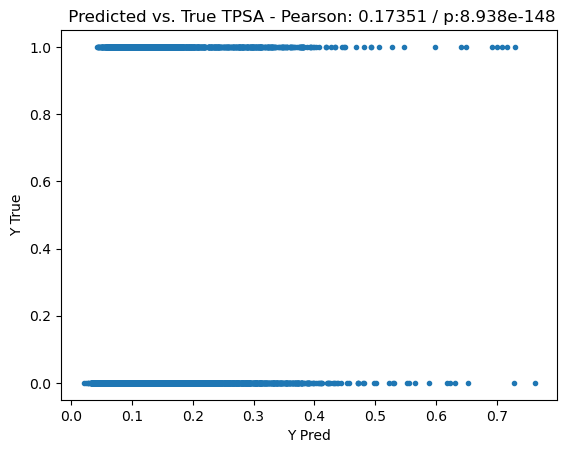

In [103]:
# fig = plt.figure(figsize=(6,6))
plt.plot(y_pred,y_test_np,  '.')
plt.title(f" Predicted vs. True TPSA - Pearson: {pearson_corr:.5f} / p:{pearson_p:.3e}")
plt.xlabel("Y Pred");
plt.ylabel("Y True");
# plt.xlim(1.775, 1.875)
# plt.xlim(1.775, 1.875)

Text(0.5, 0, 'TPSA Value')

Text(0, 0.5, 'Compounds')

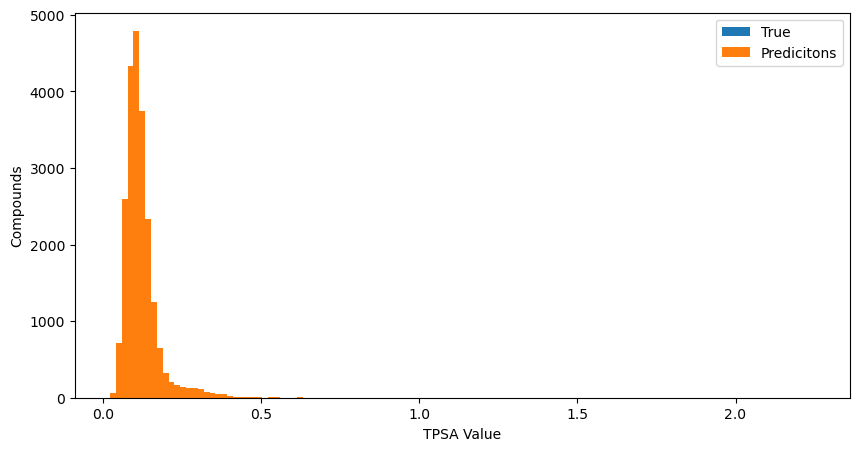

In [100]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
num_bins = 40
# fig, ax = plt.subplots()
 
# the histogram of the data

fig = plt.figure(figsize=(10,5))
n, bins, patches = plt.hist(y_test_np, num_bins, density=False, label = 'True', range=[1.5,2.25] )
# We can set the number of bins with the *bins* keyword argument.
n, bins, patches = plt.hist(y_pred, num_bins, density=False, label='Predicitons' )
plt.xlabel('TPSA Value')
plt.ylabel('Compounds')
plt.legend()
# ax.set_title('Histogram of normal distribution sample: '
#              fr'$\mu={mu:.0f}$, $\sigma={sigma:.0f}$')
# axs[1].hist(dist2, bins=n_bins)

### plot ROC and Precision-Recall Curves

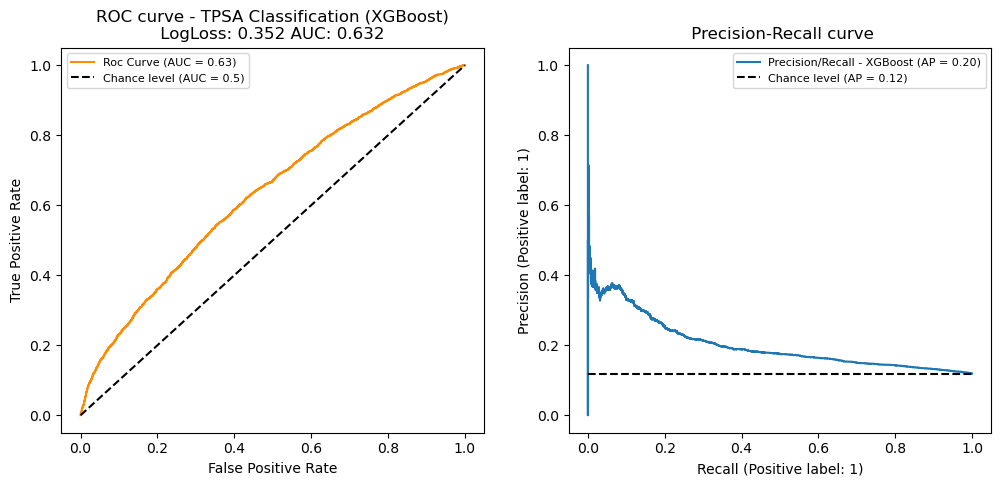

In [101]:
### from sklearn.metrics import RocCurveDisplay
# fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


roc_display = skm.RocCurveDisplay.from_predictions(
    y_test_np,
    y_pred, 
    name=f"Roc Curve",
    color="darkorange",
    plot_chance_level=True,
    ax = axes[0])

_ = roc_display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"ROC curve - TPSA Classification (XGBoost)\n LogLoss: {metrics['logloss'] :0.3f} AUC: {metrics['roc_auc']:0.3f} ",
)
_ = roc_display.ax_.legend(fontsize=8);

# prec, recall, _ = skm.precision_recall_curve(y_test, predictions, pos_label=1)
# pr_display = skm.PrecisionRecallDisplay(precision=prec, recall=recall)
pr_display = skm.PrecisionRecallDisplay.from_predictions(
    y_test_np, 
    y_pred, 
    name="Precision/Recall - XGBoost", 
    plot_chance_level=True,
    ax = axes[1])

_ = pr_display.ax_.set_title(" Precision-Recall curve");
_ = pr_display.ax_.legend(fontsize=8);
# plt.show()

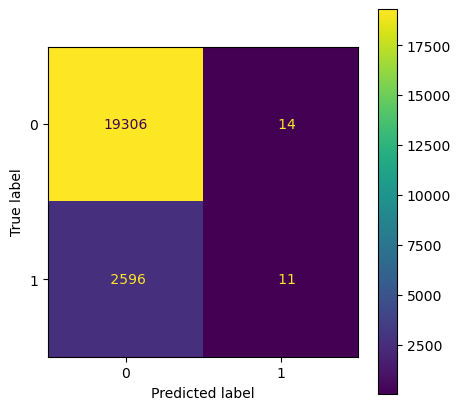

In [102]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
cm_display = skm.ConfusionMatrixDisplay.from_predictions(y_test_np, (y_pred >= 0.5), values_format="5d", ax = axes)

 # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
# roc_display.plot(ax=ax1)
# pr_display.plot(ax=ax2)
plt.show()

### Plot Feature Importance 

In [ ]:
# train_score = xgb_reg.score(train_X, train_y)
# val_score = xgb_reg.score(val_X, val_y)
# test_score = xgb_reg.score(test_X, test_y)

In [ ]:
print(f" R2 score - Training   : {train_score:0.6f}")
print(f" R2 score - Validation : {val_score:0.6f}")
print(f" R2 score - Test data  : {test_score:0.6f}")

In [ ]:
# fig = plt.figure(figsize=(20, 20))
# plt.yticks(fontsize = 12)
# ax = fig.add_subplot()
# ax.set_xlim(10,50)
ax = xgb.plot_importance(model_copy, max_num_features= None,  grid = False,  show_values = True, )
for label in ( ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(9)
ax.get_yticklabels()
# ax.autoscale(enable=None, axis="y", tight=True)

In [ ]:
from graphviz import Source 
xgb.plot_tree(model_copy,num_tress=5)

In [ ]:
# model_copy.attributes()
model_copy.feature_names
model_copy.

In [ ]:
xgb.get_config()

# Save column header names to CSV file

`binned_2sample_profiles_1482_header_info.csv` csv file as this is an old file 

In [21]:
# INPUT_FILE = "./output_11102023/2_sample_profiles/binned_2sample_profiles_w_header_000.csv"
# print(f"Reading {INPUT_FILE}")
# df = pd.read_csv(INPUT_FILE)
# df.info()
# df.iloc[:5,:15]
# df.loc[0]
# header_3681 = df.columns.to_list()
# df_header = pd.DataFrame(data=None, columns = df.columns)
# df_header
# df_header.to_csv("./output_11102023/2_sample_profiles/binned_2sample_profiles_3681_header_info.csv", index = False )

# INPUT_FILE = './output_11102023/2_sample_profiles/2sample_profiles_1482_HashOrder.csv.gz'
# print(f"Reading {INPUT_FILE}")
# df = pd.read_csv(INPUT_FILE, nrows = 5)

# df.info()
# df.iloc[:5,:15]
# df.loc[0]
# header_1482 = df.columns.to_list()
# df_header = pd.DataFrame(data=None, columns = df.columns)
# df_header
# df_header.to_csv("./output_11102023/2_sample_profiles/binned_2sample_profiles_1482_header_info.csv", index = False )

# XGBoost Classification- Development 

- Need to convert Dask data frames to dask arrays in order to use data in parm grid search

In [ ]:
files = os.walk('./output_11102023')

for i in files :
    print(i)

### Read compound profiles

In [ ]:
profileInputFiles = './output_11102023/profiles/compound_profiles_2samples_*.csv'

In [ ]:
# del df_profiles
df_profiles = read_cell_profiles(profileInputFiles, rows = 200000)

In [ ]:
type(df_profiles)
df_profiles.head(3)
df_profiles.shape

### Training initialization

In [ ]:
 
metrics_hist = defaultdict(list)
metrics_keys = ["train_auc","train_logloss", "val_auc", "val_logloss", "roc_auc", "logloss",
                "accuracy","bal_acc","top_k_acc","F1_score","map","pearson_corr"]

# print(study_params)

In [ ]:
study_params = {  "booster"            : "gbtree",
                  "device"             : "gpu",
                  "objective"          :  "binary:logistic",
                  "eval_metric"        :  ["auc", "logloss"]
                  "learning_rate"      : 0.001,    ## eta
                  "max_depth"          : 10,
                  "max_leaves"         : 10,
                  "verbosity"          : 0,
                  "min_child_weight"   : 1, 
                  "scale_pos_weight"   : 7.89,
                  "gamma"              : 0.0001,  ## min split loss 
               }

In [ ]:
iter_files = make_cv_splits(df_profiles, n_folds=5, y_columns=y_columns)

In [ ]:
xgb.__version__
xgb.config_context(device = "gpu", booster = "gbtree", verbosity = 0, validate_parameters = True ) 
# xgb.set_config(use_rmm = True, verbosity = 1)
# xgb.set_config()
# xgb.get_config()

### Beginning of loop

In [ ]:
(X_train,y_train), (X_test, y_test) = next(iter_files)

In [ ]:
logging.info(f"Building TRAINING/TEST DMatricies...")

d_train = xgb.dask.DaskDMatrix(client, X_train, y_train )
# logging.info(f"Building TRAINING DMatrix...Completed")

# logging.info(f"Building TEST DMatrix...")
d_test = xgb.dask.DaskDMatrix(client, X_test, y_test )
logging.info(f"Building TRAINING/TEST DMatricies...Completed")

In [ ]:
# X_train.shape , X_test.shape, # y_train.shape , y_test.shape
booster_model = model['booster'] if model is not None else None

In [ ]:
logging.info(f"Training model...")
model = xgb.dask.train(
    None,
    {"verbosity": 0, "tree_method": "hist", **study_params},
    d_train,
    num_boost_round=10000,
    evals=[(d_train, "train"), (d_test, "test")],
    xgb_model = booster_model,
    verbose_eval=True,
    early_stopping_rounds = 50,
)
logging.info(f"Training model...Completed")

### Run on test data and plot results 

In [ ]:
model['booster'].best_iteration, model['booster'].best_score

In [ ]:
predictions = xgb.dask.predict(client, model,d_test).compute()

y_test_c = y_test.compute().to_numpy().squeeze()


In [ ]:
print(f" y_test_c   : {type(y_test_c)} \t\t\t shape: {y_test_c.shape}")
print(f" Predictions: {type(predictions)} \t\t\t shape: {predictions.shape}")
np.bincount(y_test_c)

In [ ]:
logging.info(f"Calculating metrics...")
# R2_score = skm.r2_score(y_true = y_test_c, y_pred = predictions)
# mse_score = skm.mean_squared_error(y_true = y_test_c, y_pred = predictions, squared=False,)
# metrics_keys = ["train_auc","train_logloss", "val_auc", "val_logloss", "roc_auc", "logloss",
#                "accuracy","bal_acc","top_k_acc","F1_score","map","pearson_corr"]
metrics = compute_classification_metrics(model, y_test_c, predictions)
logging.info(f"Calculating metrics...Completed")

In [ ]:
# print(y_test_c)
# print(predictions)
print()
print(f"    log_loss :  {metrics['logloss']:9.6f}")
print(f"    Accuracy :  {metrics['accuracy']:9.6f}")
print(f" Bal. Accrcy :  {metrics['bal_acc']:9.6f}")
print(f" Top 3 Score :  {metrics['top_k_acc']:9.6f}")
print(f"    F1 Score :  {metrics['F1_score']:9.6f}")
print(f"     Pearson :  {metrics['pearson_corr']:9.6f}          P : {pearson_p:9.4e}")
print()
print(f"   Training AUC :  {metrics['train_auc']:.6f}      Logloss : {metrics['train_logloss']:.6f}")
print(f" Validation AUC :  {metrics['val_auc']:.6f}      Logloss : {metrics['val_logloss']:.6f}")
print(f"       Test AUC :  {metrics['roc_auc']:.6f}      Logloss : {metrics['logloss']:.6f}")

In [ ]:
for key in metrics_keys:
    print(f" {key:20s}:    {metrics_hist[key]}")

In [ ]:
model['booster'].best_score
model['booster'].best_iteration

### plot results

In [ ]:
### from sklearn.metrics import RocCurveDisplay
fig, axes = plt.subplots(1, 3, figsize=(16, 5))


roc_display = skm.RocCurveDisplay.from_predictions(
    y_test_c,
    predictions, 
    name=f"Roc Curve",
    color="darkorange",
    plot_chance_level=True,
    ax = axes[0]
)
_ = roc_display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"ROC curve - TPSA Classification (XGBoost)\n LogLoss: {metrics_hist['logloss'][-1]:0.3f}      AUC: {metrics_hist['roc_auc'][-1]:0.3f} ",
)
_ = roc_display.ax_.legend(fontsize=8);

# prec, recall, _ = skm.precision_recall_curve(y_test, predictions, pos_label=1)
# pr_display = skm.PrecisionRecallDisplay(precision=prec, recall=recall)
pr_display = skm.PrecisionRecallDisplay.from_predictions(
    y_test_c, 
    predictions, 
    name="Precision/Recall - XGBoost", 
    plot_chance_level=True,
    ax = axes[1]
)
_ = pr_display.ax_.set_title(" Precision-Recall curve");
_ = pr_display.ax_.legend(fontsize=8);
cm_display = skm.ConfusionMatrixDisplay.from_predictions(y_test_c, (predictions >= 0.5), values_format="5d", ax = axes[2])

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
# roc_display.plot(ax=ax1)
# pr_display.plot(ax=ax2)
# plt.show()

In [ ]:
# del d_train, d_test
del model, predictions, pearson_p
del d_train, d_test, X_train, y_train, X_test, y_test, y_test_c

### End of loop

In [ ]:
print_metric_hist(metrics_hist)

In [ ]:
# type(model)
data = { 'mse_scores' : mse_scores_np,
         'R2_scores' : R2_scores_np}
    
with open(trainingMetrics, 'wb') as f: 
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(trainingMetrics, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    data = pickle.load(f)
data